# NMR Graph 4k

In [1]:
%load_ext autoreload
%autoreload 2

import sys
from pathlib import Path

project_root = Path("/srv/home/users/anatole93cs/src/graph-nmr")
sys.path.insert(0, str(project_root))

from dgmc.datasets import GraphNmrDataset, PairData

# dataset = GraphNmrDataset(root=project_root / "data/nmr_graphs_4k_filtered_mismatches", force_reload=False)
# dataset = GraphNmrDataset(root=project_root / "data/nmr_graphs_2_easy", force_reload=True)
dataset = GraphNmrDataset(root=project_root / "data/nmr_graphs_1HS7", force_reload=True)

Processing...
1it [00:01,  1.44s/it]

Returning y_t with zeros.



Done!
/srv/home/users/anatole93cs/miniforge3/envs/graph-nmr/lib/python3.12/site-packages/torch_geometric/data/in_memory_dataset.py:131: UserWarning: Weights only load failed. Please file an issue to make `torch.load(weights_only=True)` compatible in your case. Please use `torch.serialization.add_safe_globals([dgmc.datasets.graph_nmr.PairData])` to allowlist this global.
  out = fs.torch_load(path)


In [8]:
dataset[0]

PairData(x_s=[558, 1], amino_acid_s=[558, 20], edge_index_s=[2, 12644], edge_attr_s=[12644, 1], label_s=[558], y_index_s=[558], x_t=[658, 1], amino_acid_t=[658, 20], edge_index_t=[2, 13512], edge_attr_t=[13512, 1], label_t=[658], y_t=[558], num_nodes=558, protein='1HS7')

## Individual Pair Graph Analysis

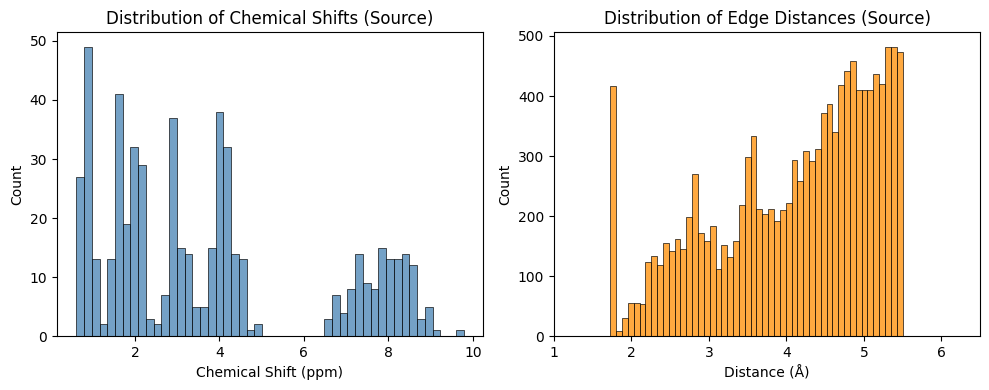

Mean degree: 22.66, Max degree: 44.00


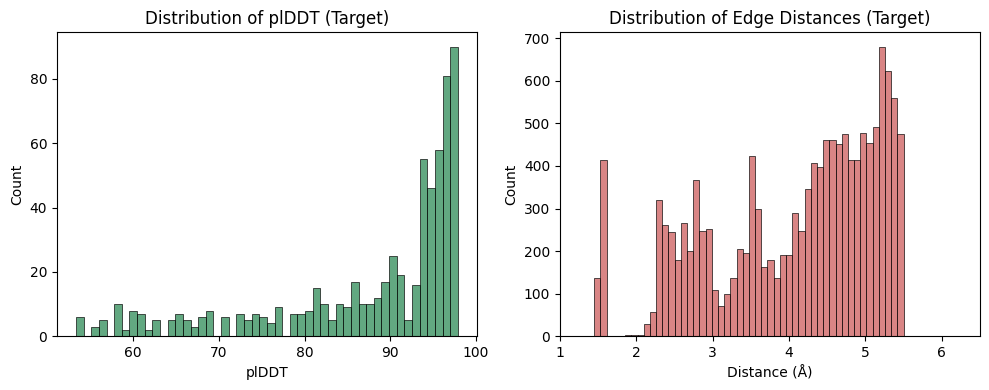

Mean degree: 20.53, Max degree: 37.00


In [9]:
import matplotlib.pyplot as plt
from torch_geometric.utils import degree
import seaborn as sns

data = dataset[0]

# 1. Source Graph
def analyze_source_graph(data):
    edge_len = data.edge_attr_s.cpu().numpy().flatten()
    x = data.x_s.cpu().numpy().flatten()

    plt.figure(figsize=(10,4))
    plt.subplot(1,2,1)
    sns.histplot(x, bins=50, color='steelblue')
    plt.xlabel('Chemical Shift (ppm)')
    plt.title('Distribution of Chemical Shifts (Source)')

    plt.subplot(1,2,2)
    sns.histplot(edge_len, bins=50, color='darkorange')
    plt.xlabel('Distance (Å)')
    plt.xlim(1, 6.5)
    plt.title('Distribution of Edge Distances (Source)')
    plt.tight_layout()
    plt.show()

    deg = degree(data.edge_index_s[0], num_nodes=data.x_s.size(0)).numpy()
    print(f"Mean degree: {deg.mean():.2f}, Max degree: {deg.max():.2f}")

analyze_source_graph(data)

# 2. Target Graph
def analyze_target_graph(data):
    edge_len = data.edge_attr_t.cpu().numpy().flatten()
    x = data.x_t.cpu().numpy().flatten()

    plt.figure(figsize=(10,4))
    plt.subplot(1,2,1)
    sns.histplot(x, bins=50, color='seagreen')
    plt.xlabel('plDDT')
    plt.title('Distribution of plDDT (Target)')

    plt.subplot(1,2,2)
    sns.histplot(edge_len, bins=50, color='indianred')
    plt.xlabel('Distance (Å)')
    plt.xlim(1, 6.5)
    plt.title('Distribution of Edge Distances (Target)')
    plt.tight_layout()
    plt.show()

    deg = degree(data.edge_index_t[0], num_nodes=data.x_t.size(0)).numpy()
    print(f"Mean degree: {deg.mean():.2f}, Max degree: {deg.max():.2f}")

analyze_target_graph(data)

## Global Analysis Across all Source and Target Graphs

100%|██████████| 4049/4049 [00:00<00:00, 4809.50it/s]


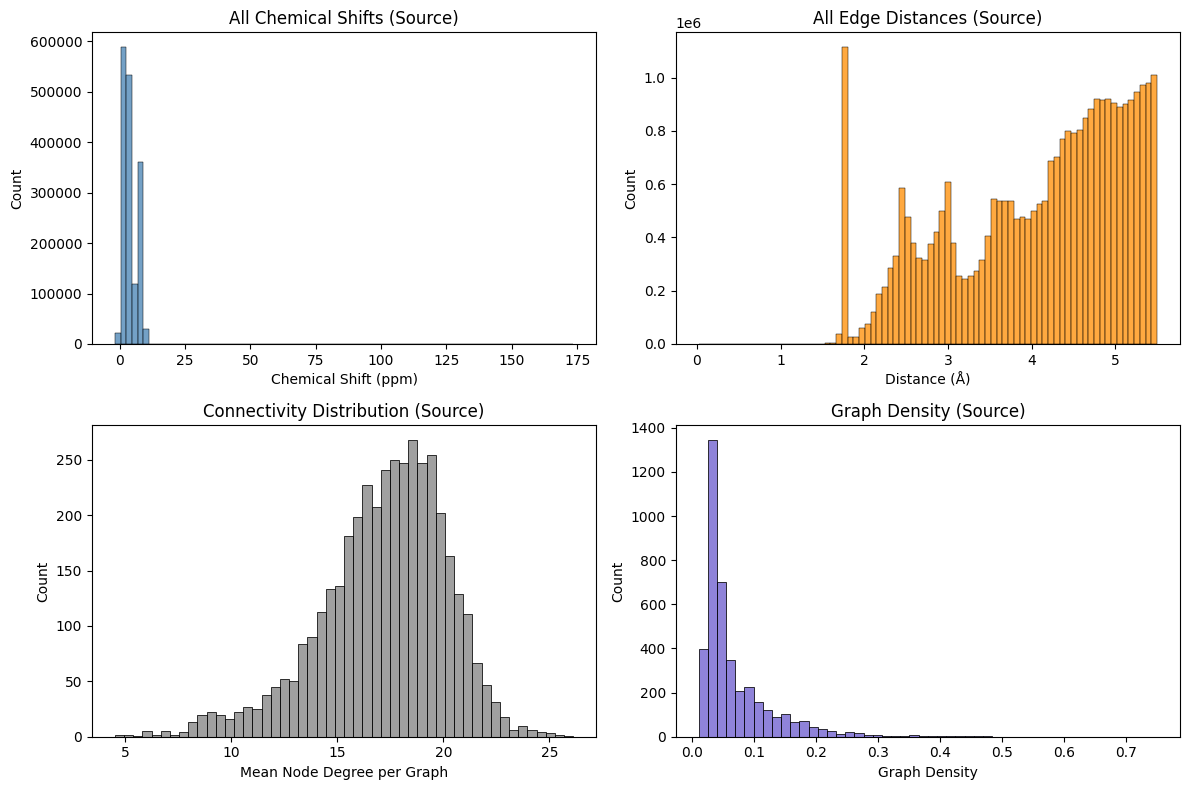

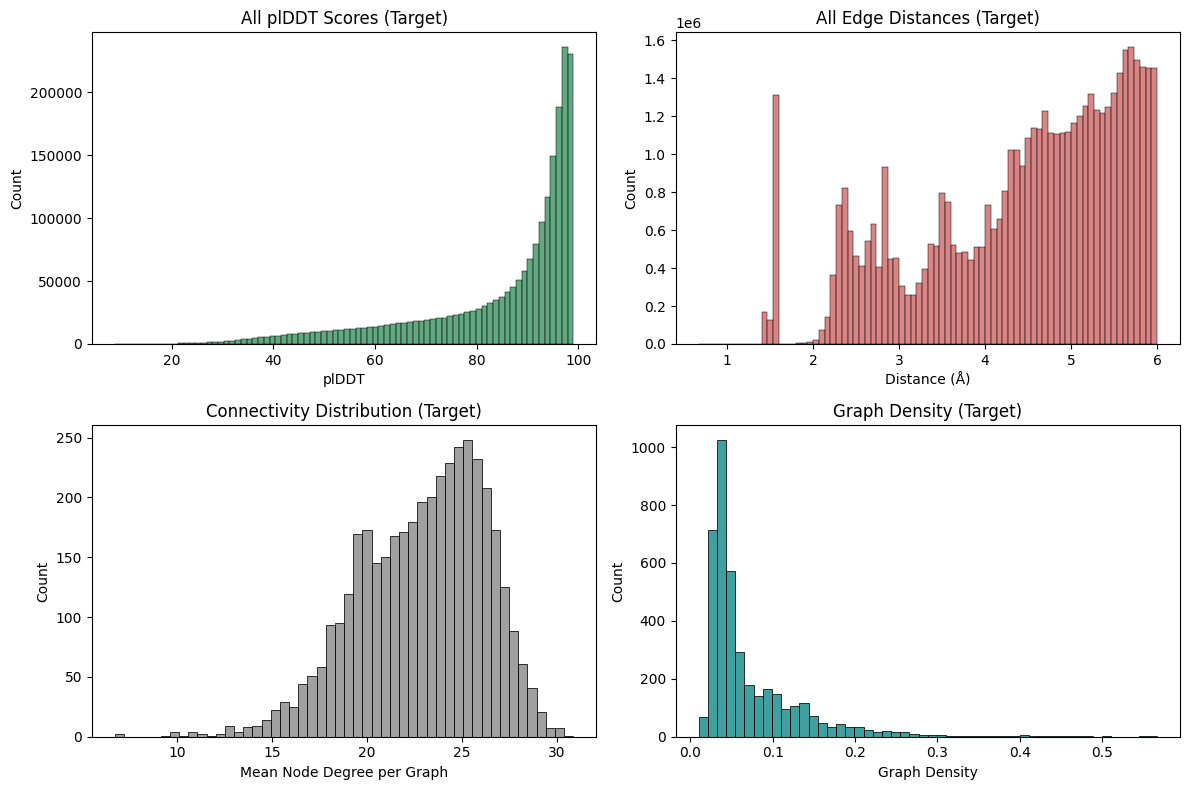

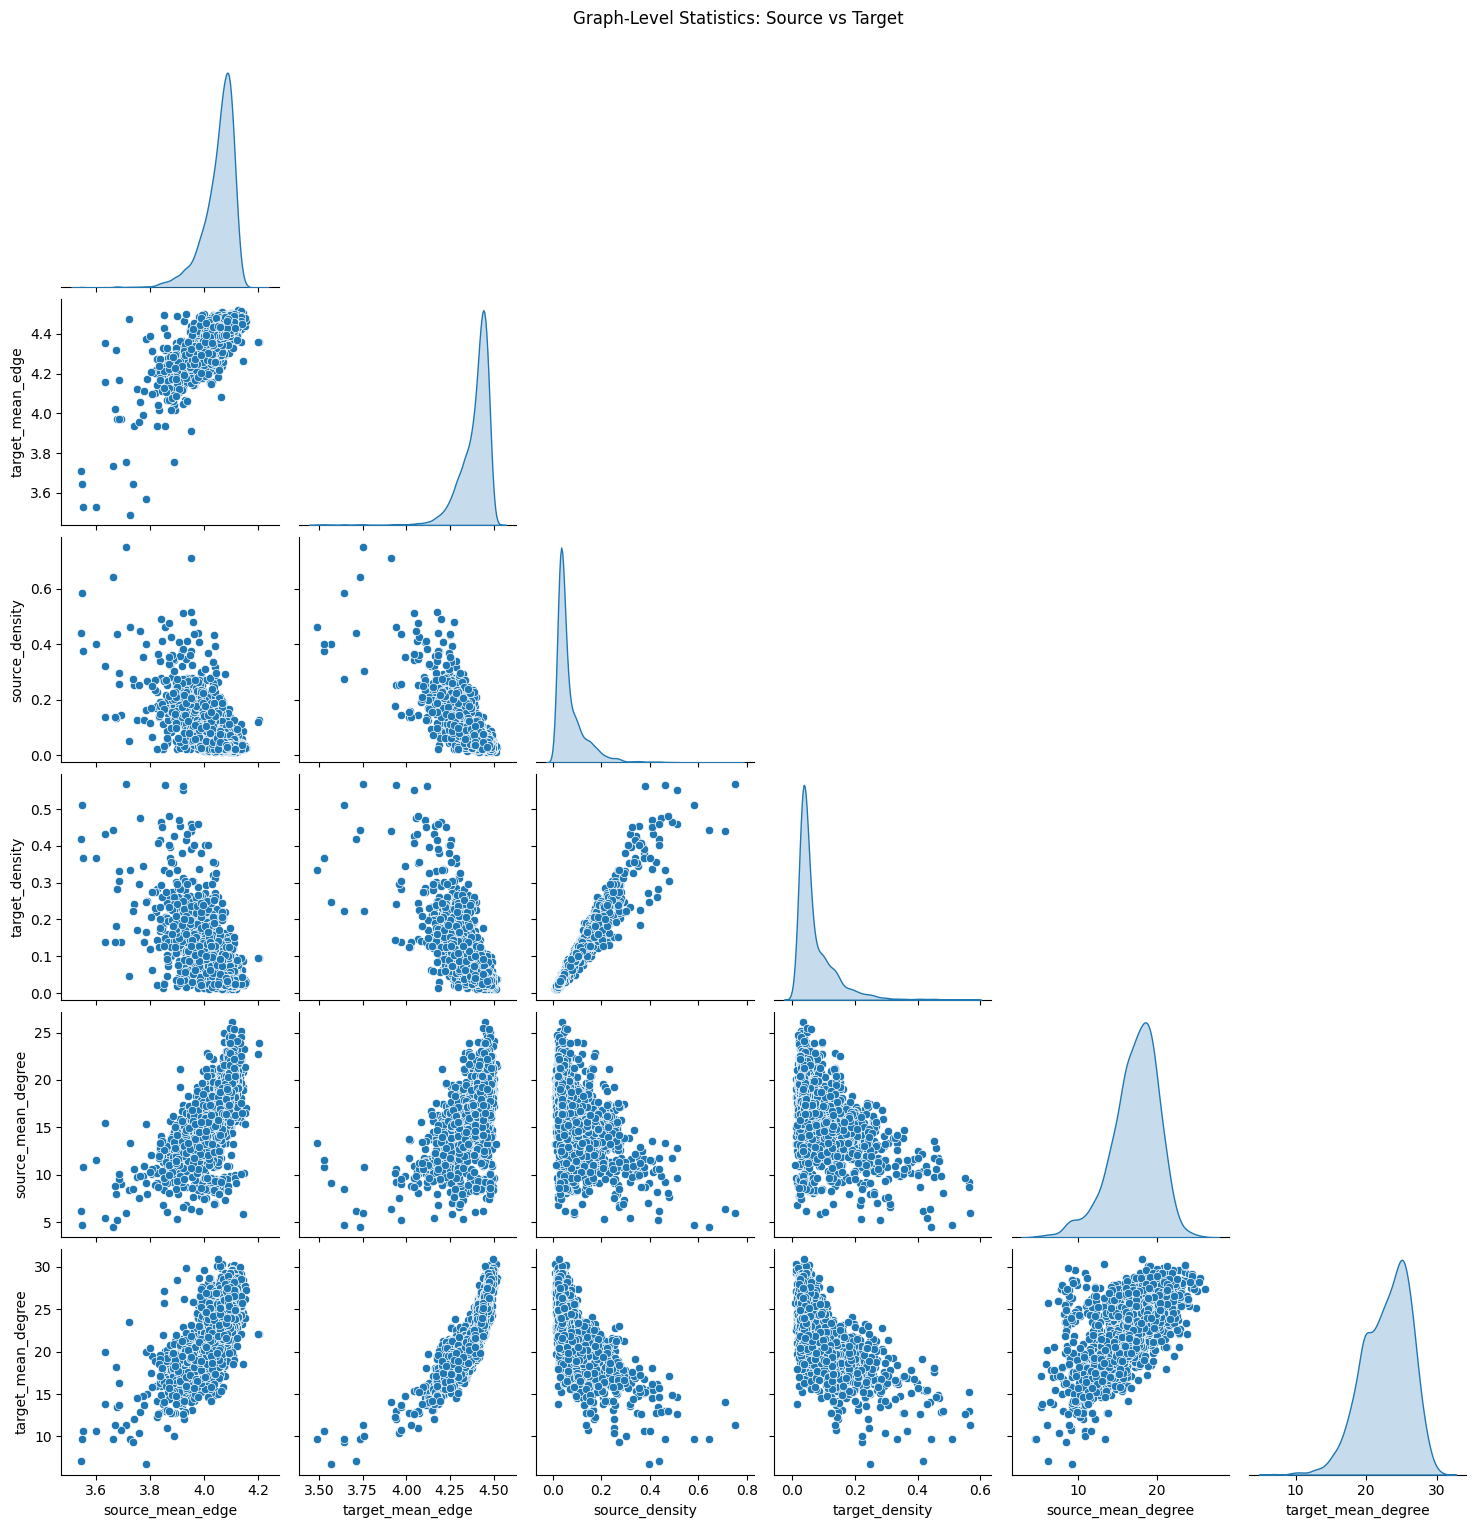

                     count    mean    std    min     25%     50%     75%  \
source_mean_edge    4049.0   4.051  0.063  3.544   4.026   4.066   4.093   
target_mean_edge    4049.0   4.391  0.087  3.491   4.356   4.417   4.448   
source_density      4049.0   0.070  0.065  0.011   0.032   0.045   0.087   
target_density      4049.0   0.073  0.064  0.010   0.034   0.047   0.091   
source_mean_degree  4049.0  17.182  2.999  4.500  15.545  17.538  19.273   
target_mean_degree  4049.0  22.898  3.358  6.714  20.529  23.331  25.455   

                       max  
source_mean_edge     4.203  
target_mean_edge     4.522  
source_density       0.750  
target_density       0.567  
source_mean_degree  26.128  
target_mean_degree  30.883  


In [ ]:
import torch
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from torch_geometric.utils import degree
from tqdm import tqdm

def collect_source_stats(dataset):
    chem_shifts_all = []
    edge_dists_all = []
    mean_x = []
    mean_edge = []
    mean_degree = []
    density = []

    for data in tqdm(dataset):
        x = data.x_s.cpu().numpy().flatten()
        edge_attr = data.edge_attr_s.cpu().numpy().flatten()
        deg = degree(data.edge_index_s[0], num_nodes=data.x_s.size(0)).numpy()

        chem_shifts_all.append(x)
        edge_dists_all.append(edge_attr)
        mean_x.append(np.mean(x))
        mean_edge.append(np.mean(edge_attr))
        mean_degree.append(np.mean(deg))
        density.append(len(edge_attr) / (data.x_s.size(0) * (data.x_s.size(0) - 1)))

    return {
        "chem_shifts": np.concatenate(chem_shifts_all),
        "edge_dists": np.concatenate(edge_dists_all),
        "mean_x": np.array(mean_x),
        "mean_edge": np.array(mean_edge),
        "mean_degree": np.array(mean_degree),
        "density": np.array(density),
    }

def collect_target_stats(dataset):
    plDDT_all = []
    edge_dists_all = []
    mean_x = []
    mean_edge = []
    mean_degree = []
    density = []

    for data in tqdm(dataset):
        x = data.x_t.cpu().numpy().flatten()
        edge_attr = data.edge_attr_t.cpu().numpy().flatten()
        deg = degree(data.edge_index_t[0], num_nodes=data.x_t.size(0)).numpy()

        plDDT_all.append(x)
        edge_dists_all.append(edge_attr)
        mean_x.append(np.mean(x))
        mean_edge.append(np.mean(edge_attr))
        mean_degree.append(np.mean(deg))
        density.append(len(edge_attr) / (data.x_t.size(0) * (data.x_t.size(0) - 1)))

    return {
        "plDDT": np.concatenate(plDDT_all),
        "edge_dists": np.concatenate(edge_dists_all),
        "mean_x": np.array(mean_x),
        "mean_edge": np.array(mean_edge),
        "mean_degree": np.array(mean_degree),
        "density": np.array(density),
    }

source_stats = collect_source_stats(dataset)
target_stats = collect_target_stats(dataset)

## Distribution Plots (All Source Graphs)
plt.figure(figsize=(12,8))
plt.subplot(2,2,1)
sns.histplot(source_stats["chem_shifts"], bins=80, color='steelblue')
plt.xlabel('Chemical Shift (ppm)')
plt.title('All Chemical Shifts (Source)')

plt.subplot(2,2,2)
sns.histplot(source_stats["edge_dists"], bins=80, color='darkorange')
plt.xlabel('Distance (Å)')
plt.title('All Edge Distances (Source)')

plt.subplot(2,2,3)
sns.histplot(source_stats["mean_degree"], bins=50, color='gray')
plt.xlabel('Mean Node Degree per Graph')
plt.title('Connectivity Distribution (Source)')

plt.subplot(2,2,4)
sns.histplot(source_stats["density"], bins=50, color='slateblue')
plt.xlabel('Graph Density')
plt.title('Graph Density (Source)')
plt.tight_layout()
plt.show()

## Distribution Plots (All Target Graphs)
plt.figure(figsize=(12,8))
plt.subplot(2,2,1)
sns.histplot(target_stats["plDDT"], bins=80, color='seagreen')
plt.xlabel('plDDT')
plt.title('All plDDT Scores (Target)')

plt.subplot(2,2,2)
sns.histplot(target_stats["edge_dists"], bins=80, color='indianred')
plt.xlabel('Distance (Å)')
plt.title('All Edge Distances (Target)')

plt.subplot(2,2,3)
sns.histplot(target_stats["mean_degree"], bins=50, color='gray')
plt.xlabel('Mean Node Degree per Graph')
plt.title('Connectivity Distribution (Target)')

plt.subplot(2,2,4)
sns.histplot(target_stats["density"], bins=50, color='teal')
plt.xlabel('Graph Density')
plt.title('Graph Density (Target)')
plt.tight_layout()
plt.show()

## Summary Comparison (Source vs Target)
import pandas as pd

summary_df = pd.DataFrame({
    "source_mean_edge": source_stats["mean_edge"],
    "target_mean_edge": target_stats["mean_edge"],
    "source_density": source_stats["density"],
    "target_density": target_stats["density"],
    "source_mean_degree": source_stats["mean_degree"],
    "target_mean_degree": target_stats["mean_degree"],
})

sns.pairplot(summary_df, corner=True, diag_kind="kde")
plt.suptitle("Graph-Level Statistics: Source vs Target", y=1.02)
plt.show()

print(summary_df.describe().T.round(3))

## Pairwise Graphs Distributions Analysis

100%|██████████| 4049/4049 [00:14<00:00, 274.92it/s]


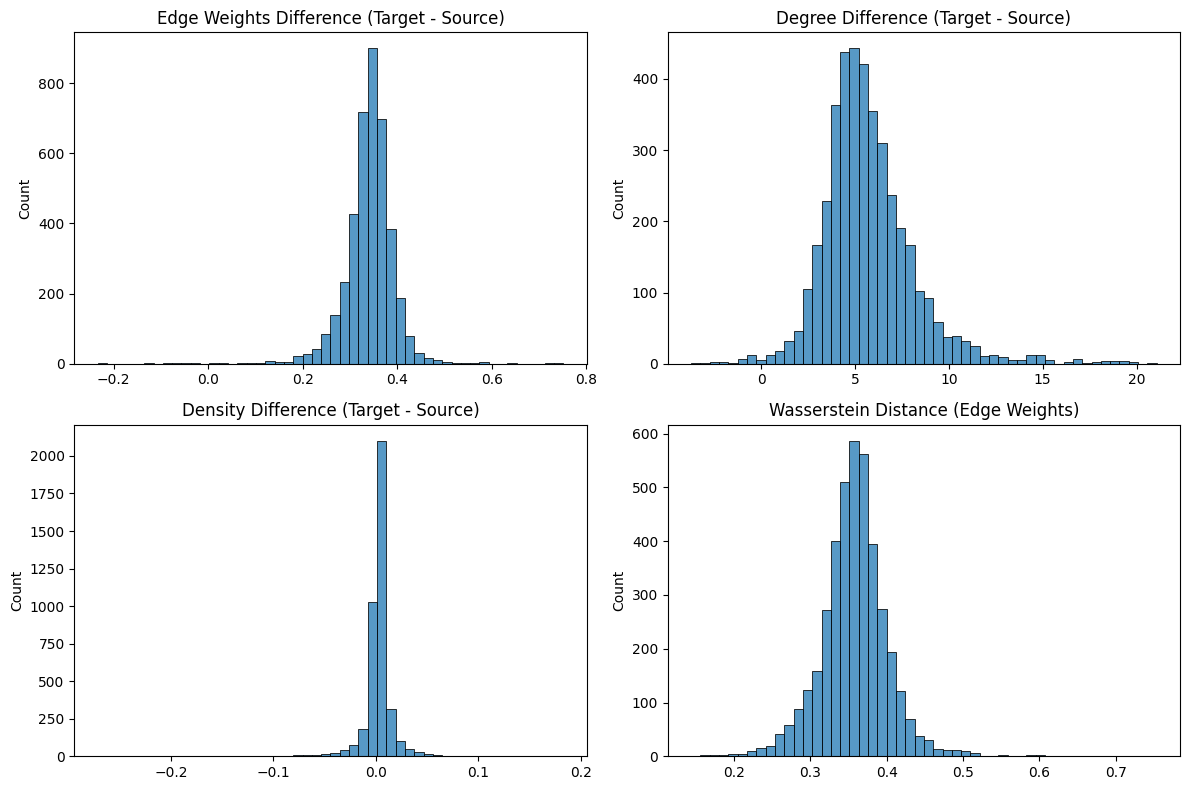

In [13]:
from scipy.stats import wasserstein_distance, pearsonr
from tqdm import tqdm
from torch_geometric.utils import degree
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


def summarize_graph_stats(edge_index, edge_attr, num_nodes):
    deg = degree(edge_index[0], num_nodes=num_nodes).numpy()
    mean_deg = np.mean(deg)
    density = edge_index.size(1) / (num_nodes * (num_nodes - 1))
    edge_dist = edge_attr.cpu().numpy().flatten()
    return {
        "mean_deg": mean_deg,
        "density": density,
        "mean_edge_len": np.mean(edge_dist),
        "std_edge_len": np.std(edge_dist),
    }


# %%
def compare_graph_pair(data):
    n_s, n_t = data.x_s.size(0), data.x_t.size(0)
    stats_s = summarize_graph_stats(data.edge_index_s, data.edge_attr_s, n_s)
    stats_t = summarize_graph_stats(data.edge_index_t, data.edge_attr_t, n_t)

    # 1. Distributional distance between edge weights
    dist_w = wasserstein_distance(
        data.edge_attr_s.cpu().numpy().flatten(), data.edge_attr_t.cpu().numpy().flatten()
    )

    # 2. High-level stats difference
    diff_deg = stats_t["mean_deg"] - stats_s["mean_deg"]
    diff_density = stats_t["density"] - stats_s["density"]
    diff_edge = stats_t["mean_edge_len"] - stats_s["mean_edge_len"]

    return {
        "Edge Weights Difference (Target - Source)": diff_edge,
        "Degree Difference (Target - Source)": diff_deg,
        "Density Difference (Target - Source)": diff_density,
        "Wasserstein Distance (Edge Weights)": dist_w,
    }


# %%
results = [compare_graph_pair(d) for d in tqdm(dataset)]
results = {k: np.array([r[k] for r in results]) for k in results[0].keys()}

# %%
plt.figure(figsize=(12, 8))
num_plots = len(results)
for i, (k, v) in enumerate(results.items(), 1):
    plt.subplot(2, 2, i)
    sns.histplot(v, bins=50)
    plt.title(k)
plt.tight_layout()
plt.show()

## Pairwise Graphs Comparison

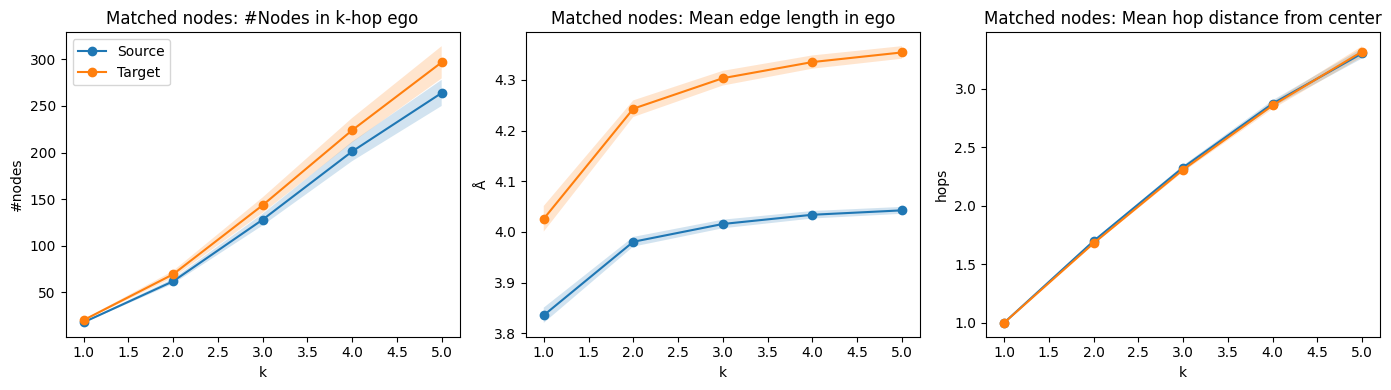

In [6]:
# # Neighborhood similarity around matched nodes
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch_geometric.utils import k_hop_subgraph, degree

def ego_metrics(edge_index, edge_attr, num_nodes, center, k_max=3):
    """
    Returns dict of lists over k=1..k_max:
      - n_nodes[k]
      - mean_edge[k]
      - mean_sps[k] (mean shortest path from center to others using hop distance)
    """
    edge_index = edge_index.cpu()
    edge_attr  = edge_attr.view(-1).float().cpu()
    out = {"n_nodes": [], "mean_edge": [], "mean_sps": []}

    # Precompute unweighted adjacency (for hop distances)
    # We’ll use hop count as a proxy for path length; it’s robust + cheap.
    for k in range(1, k_max+1):
        nodes, sub_ei, mapping, _ = k_hop_subgraph(center, k, edge_index, relabel_nodes=True, num_nodes=num_nodes)
        if nodes.numel() == 0:
            out["n_nodes"].append(0)
            out["mean_edge"].append(np.nan)
            out["mean_sps"].append(np.nan)
            continue

        # Edge lengths in subgraph
        # Map original edges to subgraph indices
        mask = torch.isin(edge_index[0], nodes) & torch.isin(edge_index[1], nodes)
        sub_edges = edge_index[:, mask]
        sub_w = edge_attr[mask]

        # Relabel to [0..m-1]
        relabel = torch.full((num_nodes,), -1, dtype=torch.long)
        relabel[nodes] = torch.arange(nodes.numel(), dtype=torch.long)
        sub_i = relabel[sub_edges]

        # Mean edge length
        mean_edge = float(sub_w.mean().item()) if sub_w.numel() > 0 else np.nan

        # Mean shortest-path (in hops) from center to others (BFS over unweighted)
        m = nodes.numel()
        A = [[] for _ in range(m)]
        si, sj = sub_i
        for a, b in zip(si.tolist(), sj.tolist()):
            A[a].append(b); A[b].append(a)
        src = int(relabel[center])
        # BFS
        dist = [-1]*m
        dist[src] = 0
        q = [src]
        head = 0
        while head < len(q):
            u = q[head]; head += 1
            for v in A[u]:
                if dist[v] == -1:
                    dist[v] = dist[u] + 1
                    q.append(v)
        dists = [d for idx,d in enumerate(dist) if (idx != src and d >= 0)]
        mean_sps = float(np.mean(dists)) if len(dists) > 0 else np.nan

        out["n_nodes"].append(m)
        out["mean_edge"].append(mean_edge)
        out["mean_sps"].append(mean_sps)

    return out

def summarize_pairs(dataset, match_pairs, k_max=3, sample=None, which="source"):
    """
    dataset: iterable of Data objects with *_s / *_t
    match_pairs: list of tuples (graph_idx, node_s, node_t) indicating matched nodes
    sample: int or None -> subsample matched pairs for speed
    which: "source", "target"
    Returns dict of arrays for each metric with shape [num_pairs, k_max]
    """
    if sample is not None and len(match_pairs) > sample:
        rng = np.random.default_rng(0)
        match_pairs = list(rng.choice(match_pairs, size=sample, replace=False))

    all_n_nodes, all_mean_edge, all_mean_sps = [], [], []

    for gidx, i_s, i_t in match_pairs:
        d = dataset[gidx]
        if which == "source":
            ei, ea, n, center = d.edge_index_s, d.edge_attr_s, d.x_s.size(0), int(i_s)
        else:
            ei, ea, n, center = d.edge_index_t, d.edge_attr_t, d.x_t.size(0), int(i_t)
        met = ego_metrics(ei, ea, n, center, k_max=k_max)
        all_n_nodes.append(met["n_nodes"])
        all_mean_edge.append(met["mean_edge"])
        all_mean_sps.append(met["mean_sps"])

    def stack_clean(x):
        X = np.array(x, dtype=float)  # [num_pairs, k_max]
        return X

    return {
        "n_nodes": stack_clean(all_n_nodes),
        "mean_edge": stack_clean(all_mean_edge),
        "mean_sps": stack_clean(all_mean_sps),
    }

def plot_profile_with_ci(x, Y, label, ax):
    """
    x: 1..k_max
    Y: [num_pairs, k_max]
    """
    mu = np.nanmean(Y, axis=0)
    se = np.nanstd(Y, axis=0) / np.sqrt(np.sum(~np.isnan(Y), axis=0))
    ax.plot(x, mu, marker='o', label=label)
    ax.fill_between(x, mu - 1.96*se, mu + 1.96*se, alpha=0.2)

def plot_neighborhood_profiles(src_stats, tgt_stats, k_max=3, title_prefix=""):
    x = np.arange(1, k_max+1)
    fig, axs = plt.subplots(1, 3, figsize=(14,4), sharex=True)

    plot_profile_with_ci(x, src_stats["n_nodes"], "Source", axs[0])
    plot_profile_with_ci(x, tgt_stats["n_nodes"], "Target", axs[0])
    axs[0].set_title(f"{title_prefix} #Nodes in k-hop ego")
    axs[0].set_xlabel("k"); axs[0].set_ylabel("#nodes"); axs[0].legend()

    plot_profile_with_ci(x, src_stats["mean_edge"], "Source", axs[1])
    plot_profile_with_ci(x, tgt_stats["mean_edge"], "Target", axs[1])
    axs[1].set_title(f"{title_prefix} Mean edge length in ego")
    axs[1].set_xlabel("k"); axs[1].set_ylabel("Å")

    plot_profile_with_ci(x, src_stats["mean_sps"], "Source", axs[2])
    plot_profile_with_ci(x, tgt_stats["mean_sps"], "Target", axs[2])
    axs[2].set_title(f"{title_prefix} Mean hop distance from center")
    axs[2].set_xlabel("k"); axs[2].set_ylabel("hops")

    plt.tight_layout()
    plt.show()

# --- Example driver ---
# Build matched triplets (graph_idx, i_s, i_t).
# If you already have y-based matches, assemble them here. Example below assumes y’s are unique per graph.

# TODO: Do uniform sampling over pairs, instead of first 50 indices
def build_matches_from_y(dataset, max_pairs_per_graph=50):
    matches = []
    for gi, d in enumerate(dataset):
        # map y value -> index for source/target
        ys_s = d.y_index_s.cpu().numpy().tolist()
        ys_t = d.y_t.cpu().numpy().tolist()
        idx_s = {y:i for i,y in enumerate(ys_s)}
        cnt = 0
        for jt, y in enumerate(ys_t):
            if y in idx_s:
                matches.append((gi, idx_s[y], jt))
                cnt += 1
                if max_pairs_per_graph and cnt >= max_pairs_per_graph:
                    break
    return matches

# Usage:
matches = build_matches_from_y(dataset, max_pairs_per_graph=50)
src_stats = summarize_pairs(dataset, matches, k_max=5, sample=500, which="source")
tgt_stats = summarize_pairs(dataset, matches, k_max=5, sample=500, which="target")
plot_neighborhood_profiles(src_stats, tgt_stats, k_max=5, title_prefix="Matched nodes:")

Computing k-hop topology & geometry diffs: 100%|██████████| 5000/5000 [01:59<00:00, 41.85it/s]
/tmp/ipykernel_1526616/3875788871.py:113: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data_per_k, labels=[str(k) for k in ks], showfliers=False)


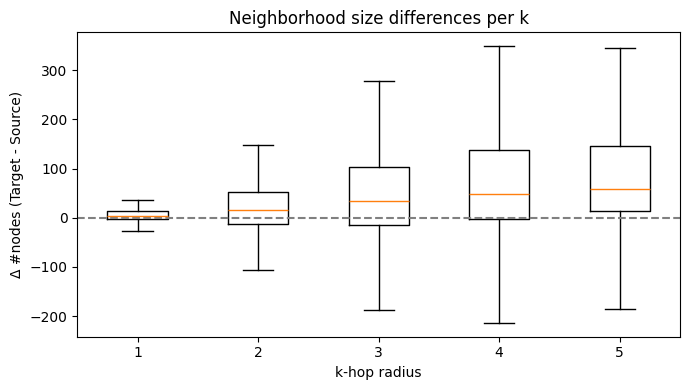


Summary for Δn (target - source):


,k,mean_n,median_n,IQR,N
0,1,4.8154,4.0,16.0,5000
1,2,21.2268,16.0,64.0,5000
2,3,45.3454,34.0,117.0,5000
3,4,65.6006,48.0,141.0,5000
4,5,78.3736,58.0,133.0,5000


/tmp/ipykernel_1526616/3875788871.py:113: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data_per_k, labels=[str(k) for k in ks], showfliers=False)


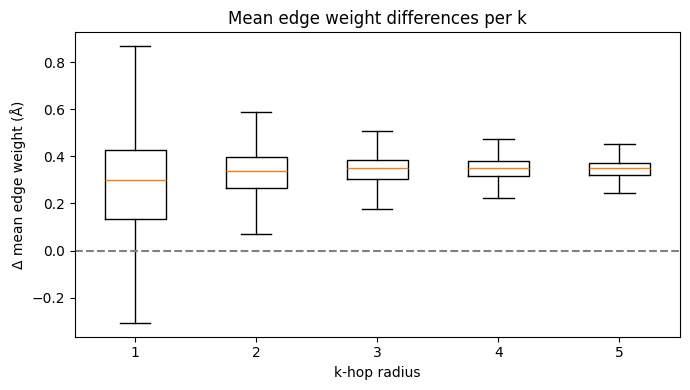


Summary for Δm (target - source):


,k,mean_m,median_m,IQR,N
0,1,0.258144,0.298931,0.293855,5000
1,2,0.313808,0.339229,0.129825,5000
2,3,0.327730,0.349201,0.083153,5000
3,4,0.332934,0.349692,0.063281,5000
4,5,0.334934,0.348587,0.052776,5000


In [7]:
# %% [markdown]
# # Direct matched-node comparison: k-hop neighborhood topology & geometry
#
# For each matched node pair (i_s, i_t) across all graph pairs:
#   - Compute for k = 1..k_max:
#       * n_s(k), n_t(k): #nodes in k-hop ego neighborhood
#       * m_s(k), m_t(k): mean edge weight (distance) inside k-hop ego
#   - Compute paired differences:
#       Δn_k = n_t(k) - n_s(k)
#       Δm_k = m_t(k) - m_s(k)
#
# Then plot per-k boxplots and print summary stats.
# This version handles large datasets via sampling (sample=N).

import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
from torch_geometric.utils import k_hop_subgraph
from tqdm import tqdm

# ==========================================================
# Utility functions
# ==========================================================

def build_matches_from_y(dataset, max_pairs_per_graph=None):
    """Build exact matches from y_s and y_t for each graph pair."""
    matches = []
    for gi, d in enumerate(dataset):
        ys_s = d.y_index_s.detach().cpu().numpy().ravel().tolist()
        ys_t = d.y_t.detach().cpu().numpy().ravel().tolist()
        s_pos = {}
        for i, y in enumerate(ys_s):
            s_pos.setdefault(y, []).append(i)
        cnt = 0
        for j, y in enumerate(ys_t):
            lst = s_pos.get(y, [])
            if lst:
                i_s = lst.pop(0)
                matches.append((gi, i_s, j))
                cnt += 1
                if max_pairs_per_graph and cnt >= max_pairs_per_graph:
                    break
    return matches

def ego_size(edge_index, num_nodes, center, k):
    """Return number of nodes in k-hop ego subgraph."""
    nodes, _, _, _ = k_hop_subgraph(center, k, edge_index, relabel_nodes=True, num_nodes=num_nodes)
    return int(nodes.numel())

def ego_mean_edge_weight(edge_index, edge_attr, num_nodes, center, k):
    """Return mean edge weight (distance) inside k-hop ego subgraph."""
    nodes, _, _, _ = k_hop_subgraph(center, k, edge_index, relabel_nodes=True, num_nodes=num_nodes)
    if nodes.numel() <= 1:
        return np.nan
    mask = torch.isin(edge_index[0], nodes) & torch.isin(edge_index[1], nodes)
    if mask.sum() == 0:
        return np.nan
    return float(edge_attr.view(-1)[mask].float().mean().item())

def compute_khop_diffs(dataset, matches, k_max=3, sample=None):
    """
    Compute both neighborhood-size and mean-edge-weight diffs for matched nodes.
    Returns DataFrame with columns:
      [graph_idx, i_s, i_t, k, n_s, n_t, m_s, m_t, diff_n, diff_m]
    """
    if sample and len(matches) > sample:
        rng = np.random.default_rng(0)
        matches = [matches[i] for i in rng.choice(len(matches), size=sample, replace=False)]

    rows = []
    for gi, i_s, i_t in tqdm(matches, desc="Computing k-hop topology & geometry diffs"):
        d = dataset[gi]
        ns, nt = d.x_s.size(0), d.x_t.size(0)
        for k in range(1, k_max + 1):
            # --- topology ---
            try:
                n_s = ego_size(d.edge_index_s, ns, int(i_s), k)
            except Exception:
                n_s = np.nan
            try:
                n_t = ego_size(d.edge_index_t, nt, int(i_t), k)
            except Exception:
                n_t = np.nan
            # --- geometry ---
            try:
                m_s = ego_mean_edge_weight(d.edge_index_s, d.edge_attr_s, ns, int(i_s), k)
            except Exception:
                m_s = np.nan
            try:
                m_t = ego_mean_edge_weight(d.edge_index_t, d.edge_attr_t, nt, int(i_t), k)
            except Exception:
                m_t = np.nan
            # --- differences ---
            diff_n = (n_t - n_s) if np.isfinite(n_s) and np.isfinite(n_t) else np.nan
            diff_m = (m_t - m_s) if np.isfinite(m_s) and np.isfinite(m_t) else np.nan
            rows.append({
                "graph_idx": gi, "i_s": i_s, "i_t": i_t, "k": k,
                "n_s": n_s, "n_t": n_t, "m_s": m_s, "m_t": m_t,
                "diff_n": diff_n, "diff_m": diff_m,
            })
    return pd.DataFrame(rows)

# ==========================================================
# Visualization helpers
# ==========================================================

def plot_diff_boxplots(df, col, ylabel, title):
    """Boxplots of paired differences per k."""
    ks = sorted(df["k"].dropna().unique().tolist())
    data_per_k = [df.loc[(df["k"]==k) & np.isfinite(df[col]), col].values for k in ks]
    plt.figure(figsize=(7,4))
    plt.boxplot(data_per_k, labels=[str(k) for k in ks], showfliers=False)
    plt.axhline(0.0, linestyle="--", color="gray")
    plt.xlabel("k-hop radius")
    plt.ylabel(ylabel)
    plt.title(title)
    plt.tight_layout()
    plt.show()

def print_diff_summary(df, col, label):
    """Print summary statistics (mean, median, IQR) per k."""
    ks = sorted(df["k"].dropna().unique().tolist())
    lines = []
    for k in ks:
        vals = df.loc[(df["k"]==k) & np.isfinite(df[col]), col].values
        if len(vals) == 0:
            lines.append((k, np.nan, np.nan, np.nan, 0))
        else:
            q25, med, q75 = np.percentile(vals, [25, 50, 75])
            lines.append((k, np.mean(vals), med, q75 - q25, len(vals)))
    out = pd.DataFrame(lines, columns=["k", f"mean_{label}", f"median_{label}", "IQR", "N"])
    print(f"\nSummary for Δ{label} (target - source):")
    display(out)

# ==========================================================
# Driver
# ==========================================================

# Build matches if not already done
matches = build_matches_from_y(dataset, max_pairs_per_graph=200)

if len(matches) == 0:
    print("⚠️ No matched nodes found across the dataset. Check y_s / y_t alignment.")
else:
    diffs_df = compute_khop_diffs(dataset, matches, k_max=5, sample=5000)

    # --- Plot and summarize neighborhood-size differences ---
    plot_diff_boxplots(diffs_df, "diff_n",
                       ylabel="Δ #nodes (Target - Source)",
                       title="Neighborhood size differences per k")
    print_diff_summary(diffs_df, "diff_n", "n")

    # --- Plot and summarize mean edge-weight differences ---
    plot_diff_boxplots(diffs_df, "diff_m",
                       ylabel="Δ mean edge weight (Å)",
                       title="Mean edge weight differences per k")
    print_diff_summary(diffs_df, "diff_m", "m")

Calculating node count differences:   0%|          | 0/4049 [00:00<?, ?it/s]

Calculating node count differences: 100%|██████████| 4049/4049 [00:00<00:00, 59759.02it/s]


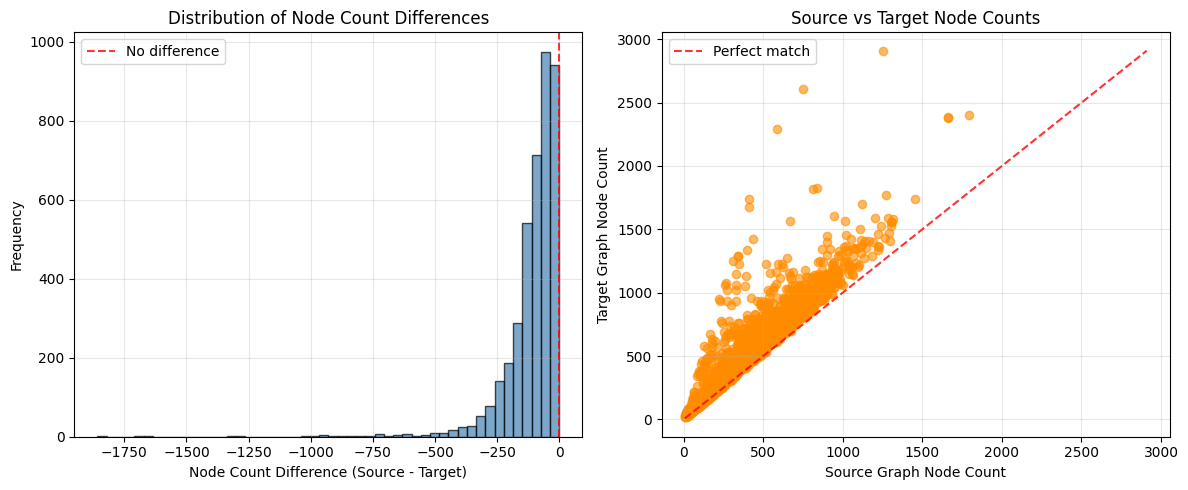

Node Count Difference Statistics:
Mean difference (Source - Target): -108.30
Median difference: -80.00
Standard deviation: 115.94
Min difference: -1858
Max difference: 0
Percentage of pairs with equal node counts: 0.1%


In [8]:
# Plot showing the difference in number of nodes between source and target graphs
def plot_node_count_differences(dataset):
    """
    Plot the distribution of node count differences (source - target) across all graph pairs.
    Positive values mean source has more nodes, negative means target has more.
    """
    node_diffs = []
    source_counts = []
    target_counts = []

    for data in tqdm(dataset, desc="Calculating node count differences"):
        n_source = data.x_s.size(0)
        n_target = data.x_t.size(0)
        diff = n_source - n_target

        node_diffs.append(diff)
        source_counts.append(n_source)
        target_counts.append(n_target)

    # Create subplots
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    # Plot 1: Histogram of node count differences
    axes[0].hist(node_diffs, bins=50, color='steelblue', alpha=0.7, edgecolor='black')
    axes[0].axvline(0, color='red', linestyle='--', alpha=0.8, label='No difference')
    axes[0].set_xlabel('Node Count Difference (Source - Target)')
    axes[0].set_ylabel('Frequency')
    axes[0].set_title('Distribution of Node Count Differences')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)

    # Plot 2: Scatter plot of source vs target node counts
    axes[1].scatter(source_counts, target_counts, alpha=0.6, color='darkorange')
    min_nodes = min(min(source_counts), min(target_counts))
    max_nodes = max(max(source_counts), max(target_counts))
    axes[1].plot([min_nodes, max_nodes], [min_nodes, max_nodes], 'r--', alpha=0.8, label='Perfect match')
    axes[1].set_xlabel('Source Graph Node Count')
    axes[1].set_ylabel('Target Graph Node Count')
    axes[1].set_title('Source vs Target Node Counts')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    # Print summary statistics
    print("Node Count Difference Statistics:")
    print(f"Mean difference (Source - Target): {np.mean(node_diffs):.2f}")
    print(f"Median difference: {np.median(node_diffs):.2f}")
    print(f"Standard deviation: {np.std(node_diffs):.2f}")
    print(f"Min difference: {np.min(node_diffs)}")
    print(f"Max difference: {np.max(node_diffs)}")
    print(f"Percentage of pairs with equal node counts: {100 * sum(d == 0 for d in node_diffs) / len(node_diffs):.1f}%")
# Execute the analysis
node_diff_stats = plot_node_count_differences(dataset)

In [9]:
# Find all proteins with positive node count differences (source - target > 0)
def find_proteins_with_positive_diff(dataset):
    """
    Find all proteins where source graph has more nodes than target graph.
    Returns a list of proteins and their node count differences.
    """
    positive_diff_proteins = []

    for data in tqdm(dataset, desc="Finding proteins with positive differences"):
        n_source = data.x_s.size(0)
        n_target = data.x_t.size(0)
        diff = n_source - n_target
        protein = data.protein

        if diff > 0:  # Source has more nodes than target
            positive_diff_proteins.append({
                'protein': protein,
                'source_nodes': n_source,
                'target_nodes': n_target,
                'difference': diff
            })

    return positive_diff_proteins

# Execute the analysis
positive_proteins = find_proteins_with_positive_diff(dataset)

print(f"Found {len(positive_proteins)} proteins with positive node count differences:")
print("=" * 60)

# Sort by difference (most positive first)
positive_proteins_sorted = sorted(positive_proteins, key=lambda x: x['difference'], reverse=True)

for i, protein_info in enumerate(positive_proteins_sorted):
    print(f"{i+1:4d}. Protein: {protein_info['protein']:8s} | "
          f"Source: {protein_info['source_nodes']:4d} | "
          f"Target: {protein_info['target_nodes']:4d} | "
          f"Diff: {protein_info['difference']:5d}")

print("=" * 60)
print(f"Total proteins with positive differences: {len(positive_proteins)}")
print(f"Total proteins in dataset: {len(dataset)}")
print(f"Percentage with positive differences: {100 * len(positive_proteins) / len(dataset):.1f}%")

# Get unique protein names for reference
unique_proteins = list(set([p['protein'] for p in positive_proteins]))
print(f"\nUnique proteins with positive differences ({len(unique_proteins)}):")
for protein in sorted(unique_proteins):
    print(f"  {protein}")

Finding proteins with positive differences: 100%|██████████| 4049/4049 [00:00<00:00, 48021.18it/s]

Found 0 proteins with positive node count differences:
Total proteins with positive differences: 0
Total proteins in dataset: 4049
Percentage with positive differences: 0.0%

Unique proteins with positive differences (0):


## Pairwise Matched Nodes Analysis

Analyzing non-matching counts: 100%|██████████| 4049/4049 [00:01<00:00, 2511.75it/s]


,graph_idx,protein,num_nodes_source,num_nodes_target,matched_nodes,unmatched_source,unmatched_target,pct_unmatched_source,pct_unmatched_target,size_diff
0,0,2LQT,347,347,243,104,104,0.299712,0.299712,0
1,1,1C3T,440,440,399,41,41,0.093182,0.093182,0
2,2,2KPW,620,620,541,79,79,0.127419,0.127419,0
3,3,2KSW,306,306,254,52,52,0.169935,0.169935,0
4,4,2K86,480,480,358,122,122,0.254167,0.254167,0
...,...,...,...,...,...,...,...,...,...,...
4044,4044,7U37,311,311,202,109,109,0.350482,0.350482,0
4045,4045,6GO0,161,161,148,13,13,0.080745,0.080745,0
4046,4046,2M1A,141,141,94,47,47,0.333333,0.333333,0
4047,4047,2IZ4,446,446,384,62,62,0.139013,0.139013,0



Summary:


,count,mean,std,min,25%,50%,75%,max
graph_idx,4049.0,2024.000000,1168.989949,0.0,1012.000000,2024.000000,3036.000000,4048.000000
num_nodes_source,4049.0,407.889355,250.983116,8.0,185.000000,397.000000,579.000000,1793.000000
num_nodes_target,4049.0,407.889355,250.983116,8.0,185.000000,397.000000,579.000000,1793.000000
matched_nodes,4049.0,332.317115,216.281593,2.0,146.000000,311.000000,484.000000,1316.000000
unmatched_source,4049.0,75.572240,60.183151,0.0,31.000000,63.000000,103.000000,699.000000
unmatched_target,4049.0,75.572240,60.183151,0.0,31.000000,63.000000,103.000000,699.000000
pct_unmatched_source,4049.0,0.201459,0.127094,0.0,0.118421,0.164634,0.245681,0.846154
pct_unmatched_target,4049.0,0.201459,0.127094,0.0,0.118421,0.164634,0.245681,0.846154
size_diff,4049.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000


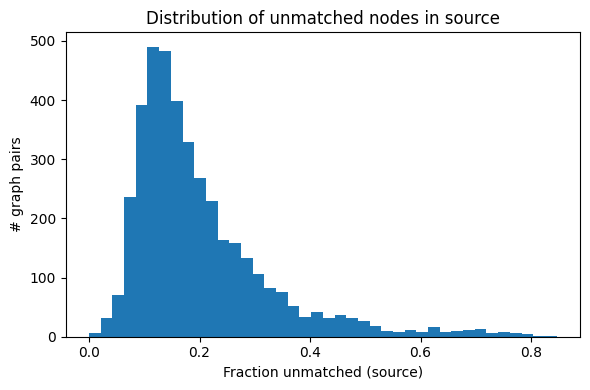

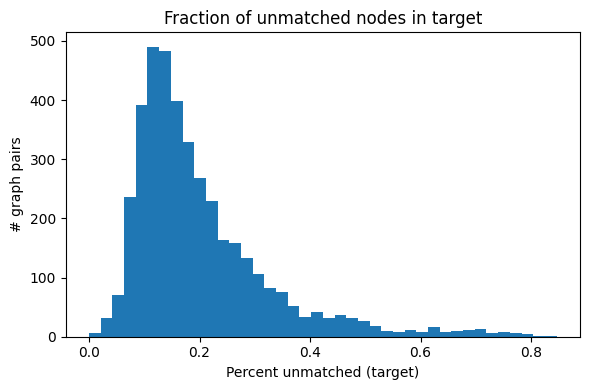

In [13]:
# %% [markdown]
# # Non-matching node counts per graph pair
# For each Data object, compare y_s vs y_t (as multisets).
# - unmatched_source: nodes in source without a counterpart in target
# - unmatched_target: nodes in target without a counterpart in source
# - matched_nodes: number of IDs matched (accounting for duplicates)
# Also records totals and percentages, then saves a CSV and plots histograms.

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
from tqdm import tqdm

def multiset_match_stats(y_s_arr, y_t_arr):
    """
    Multiset-aware matching stats for two arrays of IDs.
    Returns (matched_nodes, unmatched_source, unmatched_target).
    """
    cs = Counter(y_s_arr.tolist())
    ct = Counter(y_t_arr.tolist())
    # matched is sum of per-ID minima
    matched = sum(min(cs[k], ct.get(k, 0)) for k in cs.keys() | ct.keys())
    # unmatched are the leftovers
    unmatched_source = sum(max(0, cs[k] - ct.get(k, 0)) for k in cs)
    unmatched_target = sum(max(0, ct[k] - cs.get(k, 0)) for k in ct)
    return matched, unmatched_source, unmatched_target

rows = []
for gi, d in enumerate(tqdm(dataset, desc="Analyzing non-matching counts")):
    ys = d.y_index_s.detach().cpu().numpy().ravel()
    yt = d.y_t.detach().cpu().numpy().ravel()
    n_s = ys.size
    n_t = yt.size
    p = d.protein
    matched, unmatched_s, unmatched_t = multiset_match_stats(ys, yt)

    rows.append({
        "graph_idx": gi,
        "protein": p,
        "num_nodes_source": int(n_s),
        "num_nodes_target": int(n_t),
        "matched_nodes": int(matched),
        "unmatched_source": int(unmatched_s),
        "unmatched_target": int(unmatched_t),
        "pct_unmatched_source": float(unmatched_s / n_s) if n_s > 0 else np.nan,
        "pct_unmatched_target": float(unmatched_t / n_t) if n_t > 0 else np.nan,
        "size_diff": int(n_s - n_t),
    })

nm_df = pd.DataFrame(rows)
display(nm_df)
print("\nSummary:")
display(nm_df.describe().T)


# --- Quick visualizations ---
# Histogram: percent unmatched in source
plt.figure(figsize=(6,4))
plt.hist(nm_df["pct_unmatched_source"].dropna().values, bins=40)
plt.xlabel("Fraction unmatched (source)")
plt.ylabel("# graph pairs")
plt.title("Distribution of unmatched nodes in source")
plt.tight_layout()
plt.show()

# Histogram: percent unmatched in target
plt.figure(figsize=(6,4))
plt.hist(nm_df["pct_unmatched_target"].dropna().values, bins=40)
plt.xlabel("Percent unmatched (target)")
plt.ylabel("# graph pairs")
plt.title("Fraction of unmatched nodes in target")
plt.tight_layout()
plt.show()

In [11]:
# %% [markdown]
# # Flatten dataset into a Pandas DataFrame (node-level table)
#
# Each row corresponds to a single node in either the source or target graph.
# Columns include:
#   graph_idx  : integer index of the graph pair
#   domain     : 'source' or 'target'
#   node_idx   : local node index within that graph
#   y          : integer identifier (used for matching)
#   x          : node feature value (chemical shift or plDDT)
#   label      : atom label (e.g., 'HB2 MET 1')
# Additional attributes can easily be added.

import pandas as pd
import torch
from tqdm import tqdm

def dataset_to_node_dataframe(dataset):
    """
    Flatten the dataset into a single pandas DataFrame.
    Returns columns:
      graph_idx, domain, node_idx, y, x, label
    """
    rows = []

    for gi, data in enumerate(tqdm(dataset, desc="Flattening dataset")):
        # --- Source nodes ---
        x_s = data.x_s.detach().cpu().numpy().ravel()
        y_s = data.y_index_s.detach().cpu().numpy().ravel()
        pid = data.protein
        labels_s = [str(l) for l in data.label_s]

        for ni, (x_val, y_val, lbl) in enumerate(zip(x_s, y_s, labels_s)):
            rows.append({
                "graph_idx": gi,
                "protein_id": pid,
                "domain": "source",
                "x": x_val,
                "y": int(y_val),
                "label": lbl,
            })

        # --- Target nodes ---
        x_t = data.x_t.detach().cpu().numpy().ravel()
        y_t = data.y_t.detach().cpu().numpy().ravel()
        labels_t = [str(l) for l in data.label_t]

        for ni, (x_val, y_val, lbl) in enumerate(zip(x_t, y_t, labels_t)):
            rows.append({
                "graph_idx": gi,
                "protein_id": pid,
                "domain": "target",
                "x": x_val,
                "y": int(y_val),
                "label": lbl,
            })

    df = pd.DataFrame(rows)
    return df

# ---------------------------------------------------------
# Driver
# ---------------------------------------------------------
node_df = dataset_to_node_dataframe(dataset)

# Quick sanity check
display(node_df)
print(f"Created DataFrame with {len(node_df):,} rows ({node_df['domain'].value_counts().to_dict()})")

Flattening dataset:   0%|          | 0/4049 [00:00<?, ?it/s]

Flattening dataset: 100%|██████████| 4049/4049 [00:02<00:00, 1794.81it/s]


,graph_idx,protein_id,domain,x,y,label
0,0,2LQT,source,4.110000,0,HA ASN 14
1,0,2LQT,source,7.840000,1,H ASN 14
2,0,2LQT,source,2.470000,2,HB2 ASN 14
3,0,2LQT,source,2.420000,3,HB3 ASN 14
4,0,2LQT,source,7.430000,4,HD21 ASN 14
...,...,...,...,...,...,...
3303083,4048,2KRT,target,86.080002,793,HE2 LYS 93
3303084,4048,2KRT,target,86.080002,794,HE3 LYS 93
3303085,4048,2KRT,target,80.860001,799,HZ1 LYS 93
3303086,4048,2KRT,target,80.860001,801,HZ2 LYS 93


Created DataFrame with 3,303,088 rows ({'source': 1651544, 'target': 1651544})
